# Document Denoising



#### Often while working with pdfs and docs the most common problem faced by all of us are that several pages are not clearly visible or due to any background the texts are not clearly visible.If coupled with our camera or any pdf capturing application the Document Denoising Model can be very useful.

## Importing Dataset and Necessary Libraries

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/document.zip"
!unzip -o document.zip 
!rm document.zip

In [1]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from sklearn.model_selection import train_test_split

## Loading Dataset

In [2]:
train_files = sorted(glob("new_dataset/train/*")) 
train_cleaned_files = sorted(glob("new_dataset/train_cleaned/*"))
test_files = sorted(glob("new_dataset/test/*"))
len(train_files),len(train_cleaned_files), len(test_files)

(10010, 10010, 72)

## Building Our Model

In [4]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(filters=1, kernel_size=3, padding="same", activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)       

In [5]:
model.compile(optimizer="adam",loss="binary_crossentropy")

## Creating Train and Validation Data

In [6]:
X = []
Y = []

for files in zip(train_files,train_cleaned_files):
    img = cv2.imread(files[0],cv2.IMREAD_GRAYSCALE)/255.
    X.append(img)
    img = cv2.imread(files[1],cv2.IMREAD_GRAYSCALE)/255.
    Y.append(img)

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(10010, 32, 32) (10010, 32, 32)


In [7]:
X = X.reshape(-1,32,32,1)
Y = Y.reshape(-1,32,32,1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

## Training the Model

In [9]:
history = model.fit(x_train,y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
564/564 [==============================] - 27s 48ms/step - loss: 0.1703 - val_loss: 0.1226
Epoch 2/10
564/564 [==============================] - 27s 48ms/step - loss: 0.1159 - val_loss: 0.1098
Epoch 3/10
564/564 [==============================] - 27s 48ms/step - loss: 0.1081 - val_loss: 0.1086
Epoch 4/10
564/564 [==============================] - 27s 47ms/step - loss: 0.1038 - val_loss: 0.1012
Epoch 5/10
564/564 [==============================] - 27s 47ms/step - loss: 0.1009 - val_loss: 0.0988
Epoch 6/10
564/564 [==============================] - 27s 47ms/step - loss: 0.0990 - val_loss: 0.0972
Epoch 7/10
564/564 [==============================] - 27s 48ms/step - loss: 0.0976 - val_loss: 0.0957
Epoch 8/10
564/564 [==============================] - 27s 49ms/step - loss: 0.0966 - val_loss: 0.0956
Epoch 9/10
564/564 [==============================] - 27s 47ms/step - loss: 0.0957 - val_loss: 0.0944
Epoch 10/10
564/564 [==============================] - 27s 48ms/step - loss: 0.094

Text(0.5, 1.0, 'Loss Curves')

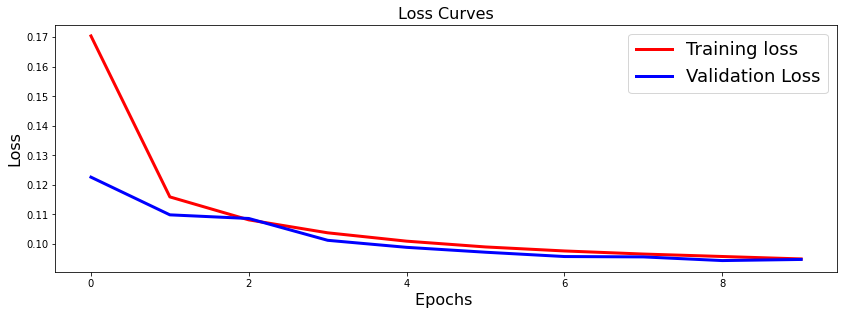

In [11]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

In [12]:
# first we have to load the image in chunks of 32x32
# for now I just crop the image to fit in 32x32
def get_chunks(file):
    page = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
    
    # getting the hight and width of the image, old_page_height and old_page_width
    oph, opw=page.shape[:2]  
    
    # getting new height and width
    # to fit the chunks in the image use max - (max%32) to get rid of the remaining.
    # it is a fast solution we can use for now
    nph, npw = oph-(oph%32),opw-(opw%32) 
    
    row_chunks=nph//32 # numober of rows
    col_chunks=npw//32 # number of chunks
    rc=0 # row counter 
    cc=0 # column counter 
    
    # the structure is convertible between chunks and the initial image
    img_chunks = np.ones((row_chunks,col_chunks,32,32,1),dtype="float32")
    
    # the paper shredder
    for row in range(0,nph,32):
        cc=0
        for col in range(0,npw,32):
            nimg = page[row:row+32,col:col+32]/255.
            nimg =np.array(nimg).reshape(32,32,1)
            try:
                img_chunks[rc,cc]=nimg
            except:
                print(rc,cc)
            cc+=1
        rc+=1
    return img_chunks


def show_chunks(chunks):
    for row in chunks:
        plt.figure(figsize=(10,10))
        for i,chunk in enumerate(row):
            plt.subplot(1,len(row),i+1)
            plt.imshow(chunk.reshape(32,32),"gray")
            plt.axis("OFF")
        plt.show()


# puting chunks together again 
def reassemble_chunks(chunks):
    # getting the page size
    oph, opw=chunks.shape[0]*32,chunks.shape[1]*32    
    
    the_page = np.ones((oph,opw),dtype="float32")
    
    for r, row in enumerate(chunks):
        r=r*32
        for c, chunk in enumerate(row):
            c=c*32
            the_page[r:r+32,c:c+32]=chunk.reshape(32,32)
            
    return the_page

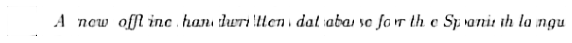

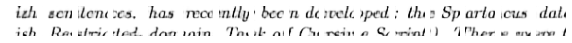

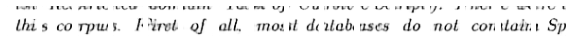

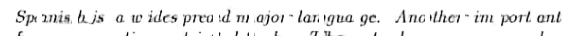

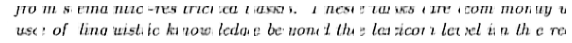

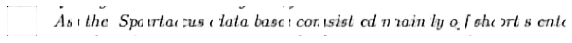

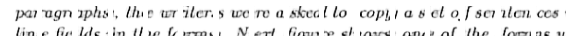

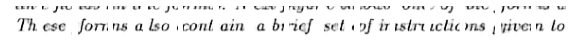

In [13]:
img = get_chunks(test_files[1])
pred_chunks = model.predict(img.reshape(-1,32,32,1))
pred_chunks = pred_chunks.reshape(img.shape)
show_chunks(pred_chunks)

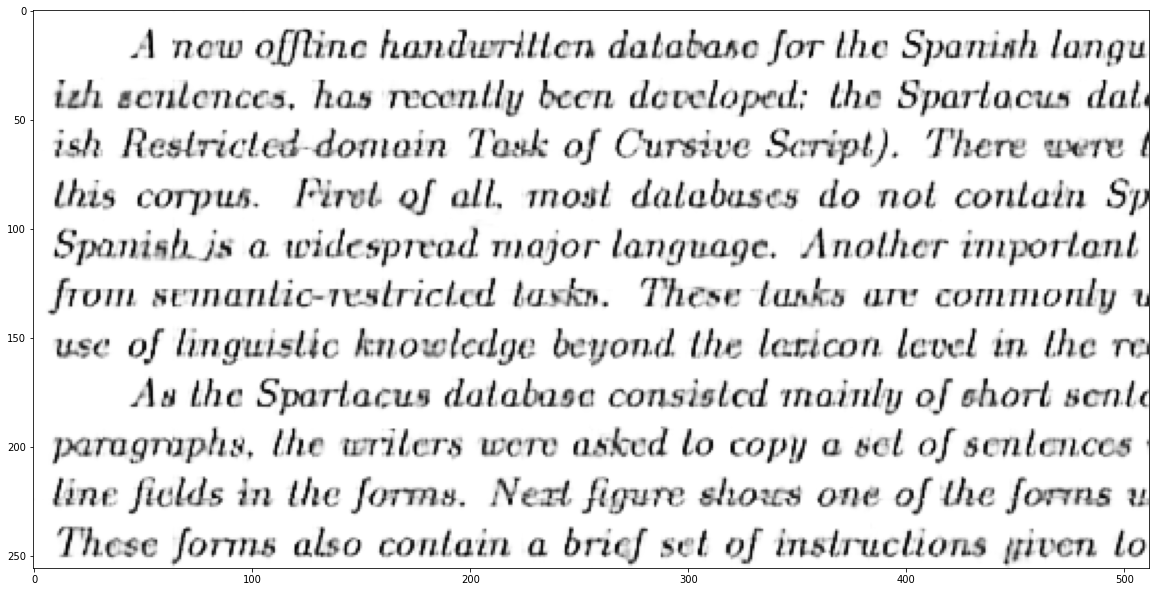

In [14]:
the_page = reassemble_chunks(pred_chunks)
plt.figure(figsize=(20,20))
plt.imshow(the_page,"gray")
plt.show()

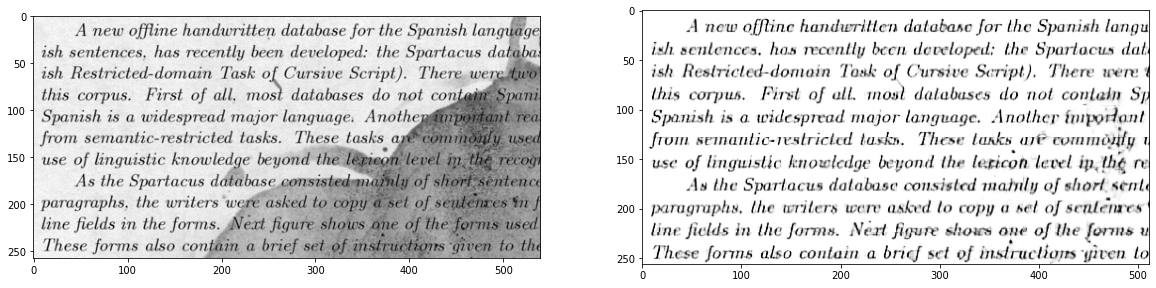

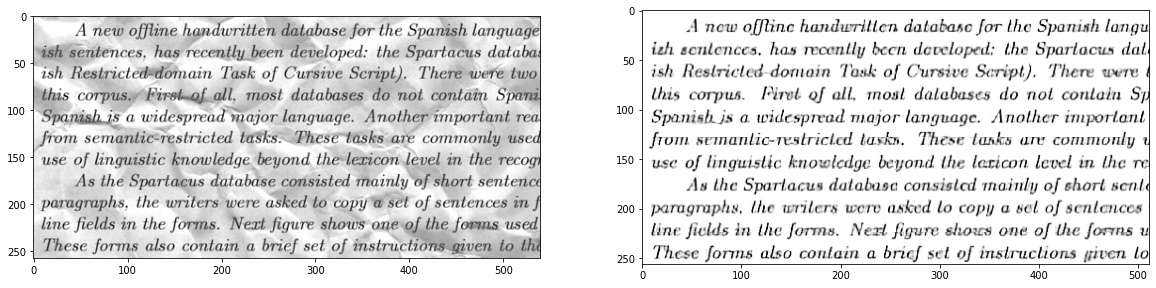

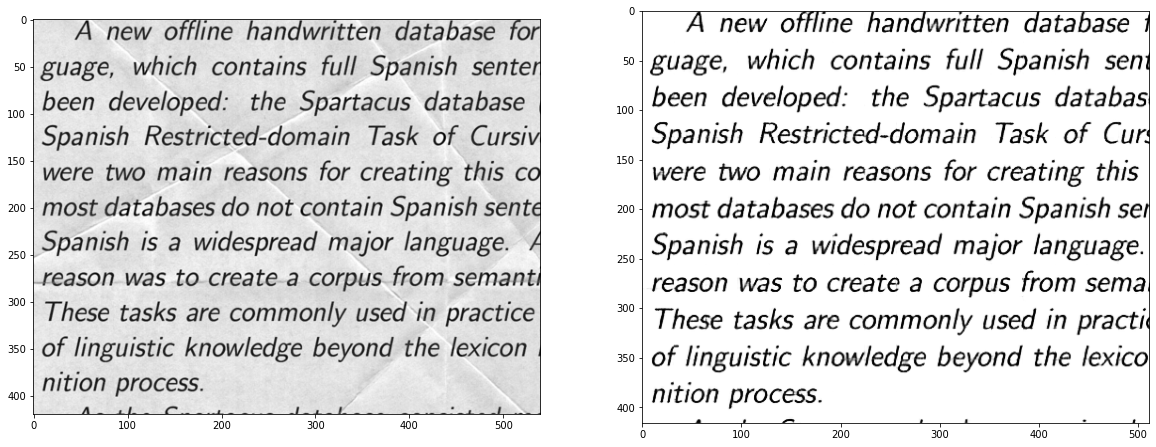

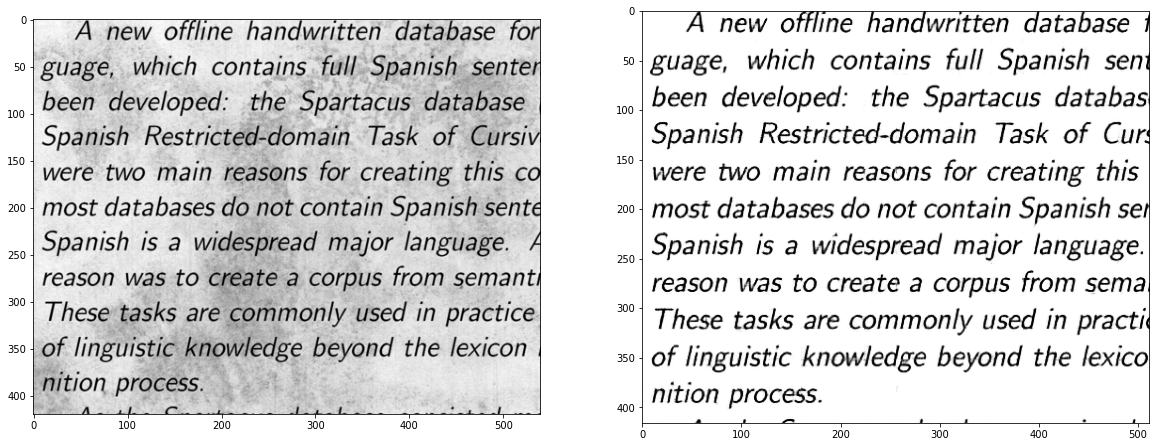

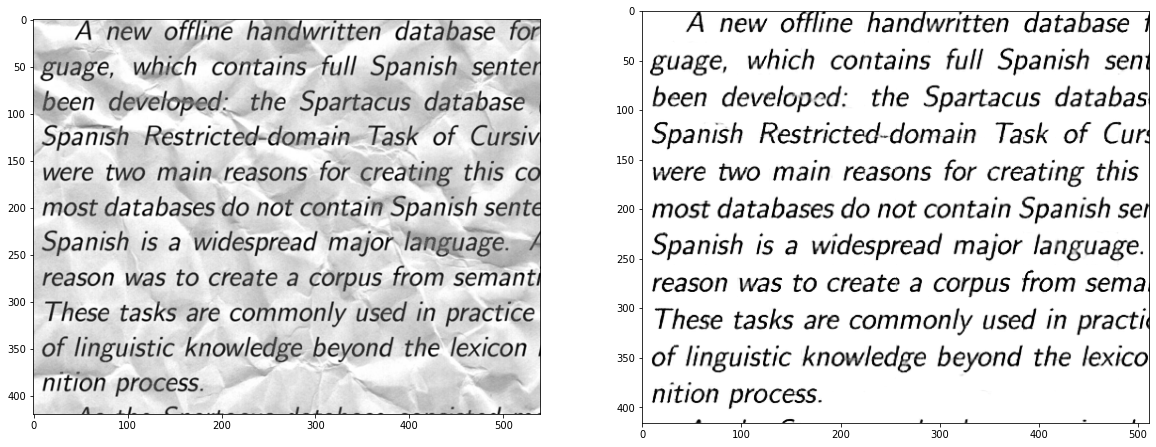

In [15]:
for file in test_files[:5]:
    test_img = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
    test_chunks = get_chunks(file)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(test_img,"gray")
    
    pred_chunks = model.predict(test_chunks.reshape(-1,32,32,1))
    pred_chunks = pred_chunks.reshape(test_chunks.shape)
    
    the_page = reassemble_chunks(pred_chunks)
    
    plt.subplot(1,2,2)
    plt.imshow(the_page,"gray")
    plt.show()
    

In [16]:
model.save("model.h5")

In [17]:
!deepCC model.h5

reading [keras model] from 'model.h5'
Saved 'model.onnx'
reading onnx model from file  model.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): graph-node conv2d_5's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_6's attribute auto_pad has no meaningful data.
WARN (ONNX): scales is not a valid graph-node attribute.
             operator Upsample will be added without this attribute.
WARN (ONNX): graph-node conv2d_7's attribute auto_pad has no meaningful data.
WARN (ONNX): scales is not a valid graph-node attribute.
             operator Upsample will be added without this attribute.
WARN (ONNX): graph-node conv2d_8's attribute auto_pad has no meaningful data.
WARN (ONNX): terminal (input/output) conv2d_4_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) conv2d_8's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (conv2d_8) as io node.
running D